In [1]:
import numpy as np
import glob
import os
from tqdm import tqdm
import re
import gc
import my_utils as myu  # Ensure 'myu' is defined with necessary functions

# root_folder_path = "/mnt/e/NeuronGrowth_2024/TTNG_05052024"
# root_folder_path = "/mnt/e/GenNDD_data"

# root_folder_path = "/ocean/projects/eng170006p/ussqww/GenNDD_data"
# ending_healthy = 160000
# ending_iterations = 190000

root_folder_path = "/ocean/projects/eng170006p/ussqww/GenNDD_data"
ending_healthy = 160000
ending_iterations = 170000

# root_folder_path = "/ocean/projects/eng170006p/ussqww/GenNDD_data_Dc"
# ending_healthy = 100000
# ending_iterations = 180000

def check_files_for_folder(folder_path, required_early=10, required_later=20, min_later_number=ending_healthy+1, last_later_threshold=ending_iterations):
    """Check the number of early and later files in the folder and ensure the last later file's number > 200,000."""
    all_vtk_files = glob.glob(os.path.join(folder_path, 'outputs/*.vtk'))  # Get all VTK files in the folder
    file_details = []
    messages = []  # List to store messages instead of printing them directly

    for file in all_vtk_files:
        try:
            num = int(file.split('_')[-1].split('.')[0])  # Extract frame number from file name
            file_details.append((file, num))
        except ValueError:
            messages.append(f"Warning: Unable to parse file number from '{file}'. Skipping this file.")

    file_details_sorted = sorted(file_details, key=lambda x: x[1])  # Sort files based on frame number

    # Separate early files (<= ending_healthy) and later files (>= min_later_number)
    early_files = [(file, num) for file, num in file_details_sorted if num <= ending_healthy]
    later_files = [(file, num) for file, num in file_details_sorted if num >= min_later_number]

    # Select a limited number of early files (maximum 10)
    if len(early_files) >= required_early:
        selected_indices_early = np.linspace(0, len(early_files) - 1, required_early, dtype=int)  # Select required_early evenly spaced files
        early_selected = [early_files[i][0] for i in selected_indices_early]  # Select only file paths
    else:
        messages.append(f"Warning: Not enough early files in '{folder_path}'. Required: {required_early}, Found: {len(early_files)}.")
        early_selected = [file for file, num in early_files]  # Select all available file paths

    # Select a limited number of later files (maximum 20)
    if len(later_files) >= required_later:
        selected_indices_later = np.linspace(0, len(later_files) - 1, required_later, dtype=int)  # Select required_later evenly spaced files
        later_selected = [later_files[i][0] for i in selected_indices_later]  # Select only file paths
    elif len(later_files) > 0:
        messages.append(f"Warning: Not enough later files in '{folder_path}'. Required: {required_later}, Found: {len(later_files)}.")
        later_selected = [file for file, num in later_files]  # Select all available file paths
    else:
        messages.append(f"Error: No files found with numbers >= {min_later_number} in '{folder_path}'. Skipping this folder.")
        return None, None, None, messages  # Skip the folder if no valid files are found

    # Handle the last file in later_files and check if it's corrupted or has an issue
    last_file, last_number = None, None
    valid_last_file = False

    for idx in reversed(range(len(later_files))):  # Loop backwards through the later_files list
        try:
            # Try to get the file and its number
            last_file = later_files[idx][0]
            last_number = later_files[idx][1]

            # Check if the file has a number > ending_iterations
            if last_number > last_later_threshold:
                valid_last_file = True
                # messages.append(f"The file '{last_file}' has a valid number > {last_later_threshold}: {last_number}.")
                break  # If the file is valid, exit the loop
            else:
                messages.append(f"Warning: The file '{last_file}' has a number <= {last_later_threshold}: {last_number}. Trying previous file.")

        except (IndexError, ValueError, OSError) as e:
            # Handle the case where the file is corrupted or unreadable
            messages.append(f"Error: Failed to process file '{last_file}' in '{folder_path}'. Error: {e}. Trying previous file.")
    
    # If no valid last file was found, skip the folder
    if not valid_last_file:
        messages.append(f"Error: No valid file with a number greater than {last_later_threshold} was found in '{folder_path}'. Skipping this folder.")
        return None, None, None, messages

    return early_selected, later_selected, last_number, messages

def find_global_bounds(subfolders):
    """Calculate global bounds based on the 30th VTK file in the later files across all subfolders."""
    global_min_x, global_min_y = float('inf'), float('inf')  # Initialize min values to infinity
    global_max_x, global_max_y = float('-inf'), float('-inf')  # Initialize max values to negative infinity

    folder_file_info = {}  # Dictionary to store file information for each folder
    problematic_folders = []  # List to collect problematic folders and issues
    all_messages = []  # List to collect all messages instead of printing

    # Loop through each subfolder to find the global bounds and gather file information
    for subfolder in tqdm(subfolders, desc="Calculating global bounds"):
        early_files, later_files, last_later_number, messages = check_files_for_folder(subfolder)
        all_messages.extend(messages)  # Collect messages from check_files_for_folder

        # Skip folder if the last_later_number is smaller than ending_iterations
        if last_later_number is not None and last_later_number < ending_iterations:
            problematic_folders.append(f"Skipping folder '{subfolder}' as last_later_number is less than ending_iterations: {last_later_number}.")
            continue

        if later_files is None:  # Skip the folder if no valid files are found
            problematic_folders.append(f"Skipping folder '{subfolder}' due to no valid later files.")
            continue

        folder_file_info[subfolder] = (early_files, later_files, last_later_number)

        # Loop through later_files in reverse to find a valid file for bounds calculation
        valid_file_found = False
        for idx in reversed(range(len(later_files))):
            last_file = later_files[idx]
            try:
                data = myu.read_mesh_cellCon_exception(last_file, 1, 0)  # Read the mesh and field data
                if data:
                    points = data[0]  # Extract points data
                    # Validate points to ensure they are numeric and finite
                    if np.isfinite(points).all():  # Ensure there are no `inf` or `nan` values in points
                        min_x, min_y = np.min(points, axis=0)  # Get min x and y values
                        max_x, max_y = np.max(points, axis=0)  # Get max x and y values
                        # Update the global bounds based on the current file
                        global_min_x = min(global_min_x, min_x)
                        global_min_y = min(global_min_y, min_y)
                        global_max_x = max(global_max_x, max_x)
                        global_max_y = max(global_max_y, max_y)
                        valid_file_found = True  # A valid file was found
                        break  # Exit loop after finding a valid file
                    else:
                        problematic_folders.append(f"Error: Invalid (non-finite) points in file '{last_file}'. Skipping.")
                else:
                    problematic_folders.append(f"Error reading mesh data for file '{last_file}' in folder '{subfolder}'. Skipping.")

            except (IndexError, ValueError, OSError) as e:
                # Handle the case where the last file is corrupted or unreadable
                problematic_folders.append(f"Error processing file '{last_file}' in folder '{subfolder}'. Error: {e}. Trying previous file.")

        # If no valid file was found, skip the folder
        if not valid_file_found:
            problematic_folders.append(f"Error: No valid file found for bounds calculation in '{subfolder}'. Skipping this folder.")
            continue

    # Print out problematic folders at the end
    if problematic_folders:
        all_messages.append("\nProblematic folders encountered:")
        all_messages.extend(problematic_folders)

    # Print all messages at once
    if all_messages:
        print("\n".join(all_messages))

    # Check if bounds are valid (ensure no inf bounds)
    if not np.isfinite([global_min_x, global_min_y, global_max_x, global_max_y]).all():
        raise ValueError("Error: Invalid global bounds detected. Check the input data.")

    # Return the global bounds and the collected file information
    return global_min_x, global_min_y, global_max_x, global_max_y, folder_file_info

def interpolate_data_for_folder(folder_path, global_bounds, file_info, grid_size=1.0):
    """Interpolate selected VTK files within a folder using specified global bounds and file information."""
    global_min_x, global_min_y, global_max_x, global_max_y = global_bounds
    x_coords = np.arange(global_min_x, global_max_x + grid_size, grid_size)
    y_coords = np.arange(global_min_y, global_max_y + grid_size, grid_size)
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T.astype(np.float32)  # Use float32 to save memory

    early_files, later_files, last_later_number = file_info  # Use the pre-collected file information

    # Skip folder if the last_later_number is smaller than ending_iterations
    if last_later_number is not None and last_later_number < ending_iterations:
        print(f"Skipping folder '{folder_path}' as last_later_number is less than ending_iterations: {last_later_number}.")
        return None, None, None

    selected_files = early_files + later_files

    if not selected_files:
        print(f"Error: No valid files selected in '{folder_path}'. Skipping this folder.")
        return None, None, None

    interpolated_data = []
    last_valid_step_data = None

    folder_name = os.path.basename(folder_path)  # Get the folder name for display
    desc = f'Interpolating in {folder_name}'  # Description for progress bar

    # Process each selected file
    with tqdm(total=len(selected_files), desc=desc, unit='file') as progress:
        for filename in selected_files:
            data = myu.read_mesh_cellCon_exception(filename, 1, 0)  # Read the mesh and field data
            if data:
                points, fields, _, _ = data  # Extract points and scalar fields
                interpolated_step_data = {}
                for field_name, values in fields.items():
                    try:
                        # Interpolate each field using the grid points
                        interpolated_values = myu.interpolate_features_cKD(points, {field_name: values}, grid_points, k=3)
                        interpolated_matrix = interpolated_values[field_name].reshape(len(y_coords), len(x_coords))
                        interpolated_step_data[field_name] = interpolated_matrix  # Store the interpolated matrix
                    except Exception as e:
                        print(f"Warning: Interpolation failed for field '{field_name}' in file '{filename}': {e}")
                        interpolated_step_data[field_name] = np.full((len(y_coords), len(x_coords)), np.nan)  # Assign NaNs on failure
                interpolated_data.append(interpolated_step_data)  # Append interpolated data for this file
                last_valid_step_data = interpolated_step_data  # Update last valid data

                # Release memory after each file is processed
                del points, fields, interpolated_step_data
                gc.collect()

            else:
                if last_valid_step_data is not None:
                    print(f"Info: Using previous valid data for file '{filename}'.")
                    interpolated_data.append(last_valid_step_data.copy())  # Use the last valid data
                else:
                    print(f"Warning: No previous valid data to duplicate for file '{filename}'. Assigning NaNs.")
                    # Assign NaNs for all fields if no previous data exists
                    duplicated_step_data = {field: np.full((len(y_coords), len(x_coords)), np.nan) for field in myu.REQUIRED_FIELDS}
                    interpolated_data.append(duplicated_step_data)

            progress.update(1)  # Update progress bar

    return interpolated_data, grid_x, grid_y  # Return the interpolated data and grid

def process_all_cases(base_path):
    """Process all cases (subfolders) in the specified base path."""
    # Get all subfolders matching the pattern io2D_ND* or io2D_* (covers both ND and numbered folders)
    subfolders = glob.glob(os.path.join(base_path, 'io2D_*'))  # Get all subfolders matching the pattern

    # Sort subfolders based on the numeric part of the folder name.
    # Handle folders like io2D_2_28, io2D_3_1, and io2D_ND01.
    def sort_key(folder):
        basename = os.path.basename(folder)
        match = re.search(r'ND(\d+)', basename)  # Match ND pattern
        if match:
            return int(match.group(1))  # Sort ND folders by their number
        match = re.search(r'io2D_(\d+)_(\d+)', basename)  # Match io2D_2_28 pattern
        if match:
            return int(match.group(1)) * 100 + int(match.group(2))  # Sort by major and minor numbers
        return float('inf')  # Place unknown patterns at the end
    
    subfolders.sort(key=sort_key)

    # Unpack all four global bounds (min_x, min_y, max_x, max_y) and file info
    global_min_x, global_min_y, global_max_x, global_max_y, folder_file_info = find_global_bounds(subfolders)
    
    global_bounds = (global_min_x, global_min_y, global_max_x, global_max_y)  # Pack global bounds into a tuple
    print(f"Global bounds determined: {global_bounds}")
    
    cases_data = {}  # Dictionary to store the interpolated data for each case

    # Process each subfolder
    for subfolder in subfolders:
        file_info = folder_file_info.get(subfolder)  # Retrieve file info for this folder
        if file_info:  # Only proceed if valid file info is available
            interpolated_data, grid_x, grid_y = interpolate_data_for_folder(subfolder, global_bounds, file_info)
            if interpolated_data is not None:
                case_name = os.path.basename(subfolder)  # Get the case name (subfolder name)
                cases_data[case_name] = (interpolated_data, grid_x, grid_y)  # Store the interpolated data
            else:
                print(f"Warning: No data interpolated for folder '{subfolder}'.")
        else:
            print(f"Skipping folder '{subfolder}' due to insufficient files.")

    return cases_data  # Return the processed data for all cases

all_cases_data = process_all_cases(root_folder_path)

Calculating global bounds:   0%|          | 0/209 [00:00<?, ?it/s]

Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND01/outputs/physics_allparticle_275800.vtk': could not convert string to float: ''. Skipping this file.


Calculating global bounds:   1%|          | 2/209 [00:01<02:06,  1.64it/s]

Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND03/outputs/physics_allparticle_254100.vtk': could not convert string to float: ''. Skipping this file.


Calculating global bounds:   2%|▏         | 4/209 [00:02<01:35,  2.14it/s]

Error: Missing required fields ['phi'] in file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND05/outputs/physics_allparticle_222000.vtk'. Skipping this file.


Calculating global bounds:   5%|▍         | 10/209 [00:04<01:19,  2.50it/s]

Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND11/outputs/physics_allparticle_277400.vtk': could not convert string to float: ''. Skipping this file.


Calculating global bounds:  14%|█▍        | 30/209 [00:13<01:07,  2.65it/s]

Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND31/outputs/physics_allparticle_225300.vtk': could not convert string to float: ''. Skipping this file.


Calculating global bounds:  15%|█▌        | 32/209 [00:14<01:17,  2.29it/s]

Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND33/outputs/physics_allparticle_224800.vtk': could not convert string to float: ''. Skipping this file.


Calculating global bounds:  26%|██▋       | 55/209 [00:23<00:58,  2.62it/s]

Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND56/outputs/physics_allparticle_306100.vtk': could not convert string to float: ''. Skipping this file.


Calculating global bounds:  29%|██▊       | 60/209 [00:24<00:52,  2.82it/s]

Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND61/outputs/physics_allparticle_241400.vtk': could not convert string to float: ''. Skipping this file.


Calculating global bounds:  34%|███▍      | 71/209 [00:29<00:52,  2.62it/s]

Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND72/outputs/physics_allparticle_234200.vtk': could not convert string to float: ''. Skipping this file.


Calculating global bounds:  35%|███▍      | 73/209 [00:30<00:57,  2.38it/s]

Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND74/outputs/physics_allparticle_232000.vtk': could not convert string to float: ''. Skipping this file.


Calculating global bounds:  43%|████▎     | 90/209 [00:37<00:48,  2.45it/s]

Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND91/outputs/physics_allparticle_208800.vtk': could not convert string to float: ''. Skipping this file.


Calculating global bounds:  54%|█████▍    | 113/209 [00:51<01:17,  1.25it/s]

Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_13/outputs/physics_allparticle_213300.vtk': could not convert string to float: ''. Skipping this file.


Calculating global bounds: 100%|██████████| 209/209 [01:12<00:00,  2.89it/s]


Error: No valid file with a number greater than 170000 was found in '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_1'. Skipping this folder.
Error: No files found with numbers >= 160001 in '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_4'. Skipping this folder.
Error: No files found with numbers >= 160001 in '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_17'. Skipping this folder.
Error: No files found with numbers >= 160001 in '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_19'. Skipping this folder.
Error: No files found with numbers >= 160001 in '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_20'. Skipping this folder.
Error: No files found with numbers >= 160001 in '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_22'. Skipping this folder.
Error: No files found with numbers >= 160001 in '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_24'. Skipping this folder.
Error: No files found with numbers >= 160001 in '/ocean/projects/eng170006p/uss

Interpolating in io2D_ND01: 100%|██████████| 30/30 [00:13<00:00,  2.25file/s]


Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND01/outputs/physics_allparticle_275800.vtk': could not convert string to float: ''. Skipping this file.
Info: Using previous valid data for file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND01/outputs/physics_allparticle_275800.vtk'.


Interpolating in io2D_ND03: 100%|██████████| 30/30 [00:13<00:00,  2.20file/s]


Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND03/outputs/physics_allparticle_254100.vtk': could not convert string to float: ''. Skipping this file.
Info: Using previous valid data for file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND03/outputs/physics_allparticle_254100.vtk'.


Interpolating in io2D_ND05: 100%|██████████| 30/30 [00:14<00:00,  2.04file/s]


Error: Missing required fields ['phi'] in file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND05/outputs/physics_allparticle_222000.vtk'. Skipping this file.
Info: Using previous valid data for file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND05/outputs/physics_allparticle_222000.vtk'.


Interpolating in io2D_ND11: 100%|██████████| 30/30 [00:12<00:00,  2.32file/s]


Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND11/outputs/physics_allparticle_277400.vtk': could not convert string to float: ''. Skipping this file.
Info: Using previous valid data for file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND11/outputs/physics_allparticle_277400.vtk'.


Interpolating in io2D_ND31: 100%|██████████| 30/30 [00:15<00:00,  1.96file/s]


Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND31/outputs/physics_allparticle_225300.vtk': could not convert string to float: ''. Skipping this file.
Info: Using previous valid data for file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND31/outputs/physics_allparticle_225300.vtk'.


Interpolating in io2D_ND33: 100%|██████████| 30/30 [00:15<00:00,  1.97file/s]


Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND33/outputs/physics_allparticle_224800.vtk': could not convert string to float: ''. Skipping this file.
Info: Using previous valid data for file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND33/outputs/physics_allparticle_224800.vtk'.


Interpolating in io2D_ND56: 100%|██████████| 30/30 [00:11<00:00,  2.52file/s]


Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND56/outputs/physics_allparticle_306100.vtk': could not convert string to float: ''. Skipping this file.
Info: Using previous valid data for file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND56/outputs/physics_allparticle_306100.vtk'.


Interpolating in io2D_ND61: 100%|██████████| 30/30 [00:15<00:00,  1.96file/s]


Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND61/outputs/physics_allparticle_241400.vtk': could not convert string to float: ''. Skipping this file.
Info: Using previous valid data for file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND61/outputs/physics_allparticle_241400.vtk'.


Interpolating in io2D_ND72: 100%|██████████| 30/30 [00:14<00:00,  2.02file/s]


Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND72/outputs/physics_allparticle_234200.vtk': could not convert string to float: ''. Skipping this file.
Info: Using previous valid data for file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND72/outputs/physics_allparticle_234200.vtk'.


Interpolating in io2D_ND74: 100%|██████████| 30/30 [00:14<00:00,  2.02file/s]


Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND74/outputs/physics_allparticle_232000.vtk': could not convert string to float: ''. Skipping this file.
Info: Using previous valid data for file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND74/outputs/physics_allparticle_232000.vtk'.


Interpolating in io2D_ND91: 100%|██████████| 30/30 [00:16<00:00,  1.81file/s]


Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND91/outputs/physics_allparticle_208800.vtk': could not convert string to float: ''. Skipping this file.
Info: Using previous valid data for file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_ND91/outputs/physics_allparticle_208800.vtk'.


Interpolating in io2D_2_0: 100%|██████████| 30/30 [00:25<00:00,  1.17file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_1' due to insufficient files.


Interpolating in io2D_2_3: 100%|██████████| 30/30 [00:28<00:00,  1.07file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_4' due to insufficient files.


Interpolating in io2D_2_13: 100%|██████████| 30/30 [00:26<00:00,  1.11file/s]


Error processing file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_13/outputs/physics_allparticle_213300.vtk': could not convert string to float: ''. Skipping this file.
Info: Using previous valid data for file '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_13/outputs/physics_allparticle_213300.vtk'.


Interpolating in io2D_2_16: 100%|██████████| 30/30 [00:22<00:00,  1.33file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_17' due to insufficient files.


Interpolating in io2D_2_18: 100%|██████████| 30/30 [00:25<00:00,  1.18file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_19' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_20' due to insufficient files.


Interpolating in io2D_2_21: 100%|██████████| 30/30 [00:22<00:00,  1.35file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_22' due to insufficient files.


Interpolating in io2D_2_23: 100%|██████████| 30/30 [00:25<00:00,  1.18file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_24' due to insufficient files.


Interpolating in io2D_2_25: 100%|██████████| 30/30 [00:28<00:00,  1.05file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_26' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_27' due to insufficient files.


Interpolating in io2D_2_28: 100%|██████████| 30/30 [00:28<00:00,  1.06file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_29' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_30' due to insufficient files.


Interpolating in io2D_2_33: 100%|██████████| 30/30 [00:23<00:00,  1.26file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_34' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_35' due to insufficient files.


Interpolating in io2D_2_36: 100%|██████████| 30/30 [00:27<00:00,  1.07file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_37' due to insufficient files.


Interpolating in io2D_2_39: 100%|██████████| 30/30 [00:27<00:00,  1.11file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_40' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_41' due to insufficient files.


Interpolating in io2D_2_42: 100%|██████████| 30/30 [00:28<00:00,  1.07file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_43' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_44' due to insufficient files.


Interpolating in io2D_2_45: 100%|██████████| 30/30 [00:29<00:00,  1.03file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_46' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_47' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_48' due to insufficient files.


Interpolating in io2D_2_49: 100%|██████████| 30/30 [00:29<00:00,  1.02file/s]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_2_50' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_0' due to insufficient files.


Interpolating in io2D_3_1: 100%|██████████| 30/30 [00:31<00:00,  1.05s/file]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_2' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_3' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_4' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_5' due to insufficient files.


Interpolating in io2D_3_6: 100%|██████████| 30/30 [00:33<00:00,  1.13s/file]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_7' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_8' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_9' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_10' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_11' due to insufficient files.


Interpolating in io2D_3_12: 100%|██████████| 30/30 [00:32<00:00,  1.08s/file]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_13' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_14' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_15' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_16' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_17' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_18' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_19' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_20' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_21' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_22' due to insufficie

Interpolating in io2D_3_23: 100%|██████████| 30/30 [00:34<00:00,  1.14s/file]


Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_24' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_25' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_26' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_27' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_28' due to insufficient files.


Interpolating in io2D_3_29: 100%|██████████| 30/30 [00:28<00:00,  1.05file/s]

Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_3_30' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_4_0' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_4_1' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_4_2' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_4_3' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_4_4' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_4_5' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_4_6' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_4_7' due to insufficient files.
Skipping folder '/ocean/projects/eng170006p/ussqww/GenNDD_data/io2D_4_8' due to insufficient files.

In [2]:
import numpy as np
from scipy.ndimage import zoom

def downsample_all_cases_data(all_cases_data, target_size=(256, 256)):
    """
    Downsamples each dataset from (241, 241) to (160, 280) for each image and the grid in all_cases_data.

    Args:
    all_cases_data (dict): Dictionary with keys as case identifiers and values as tuples of
                           (interpolated_data, grid_x, grid_y) where interpolated_data is a list of dictionaries
                           of shape (#time, #channel, 241, 241).
    target_size (tuple): Target downsample size, default (160, 280).

    Returns:
    dict: A dictionary with the same keys and downsampled data as values. Each case will have:
          (downsampled_interpolated_data, downsampled_grid_x, downsampled_grid_y).
    """
    downsampled_data = {}

    for key, (interpolated_data, grid_x, grid_y) in all_cases_data.items():
        time_steps = len(interpolated_data)
        channels = interpolated_data[0].keys()  # Assuming all time steps have the same channels
        downsampled_tensor = []

        # Downsample the grid_x and grid_y to (160, 280)
        zoom_factor_grid_x = target_size[0] / grid_x.shape[0]
        zoom_factor_grid_y = target_size[1] / grid_y.shape[1]
        downsampled_grid_x = zoom(grid_x, zoom_factor_grid_x, order=1)  # Bilinear interpolation
        downsampled_grid_y = zoom(grid_y, zoom_factor_grid_y, order=1)

        # Downsample the interpolated_data (each time step and channel)
        for time_step in interpolated_data:
            downsampled_channels = {}
            for channel in channels:
                image = time_step[channel]  # Get the image for this channel
                # Calculate the zoom factor for the image
                zoom_factor_image_x = target_size[0] / image.shape[0]
                zoom_factor_image_y = target_size[1] / image.shape[1]
                # Downsample the image
                downsampled_image = zoom(image, (zoom_factor_image_x, zoom_factor_image_y), order=1)  # Bilinear interpolation (order=1)
                downsampled_channels[channel] = downsampled_image
            downsampled_tensor.append(downsampled_channels)

        # Store the downsampled data for this case
        downsampled_data[key] = (downsampled_tensor, downsampled_grid_x, downsampled_grid_y)

    return downsampled_data

# Example usage
# Assuming `all_cases_data` is your loaded dataset
all_cases_data = downsample_all_cases_data(all_cases_data, target_size=(256, 256))

In [3]:
def check_consistent_dimensions_all_channels(all_cases_data):
    """
    Check if the dimensions of all channels are consistent across all cases in the dataset.

    Args:
        all_cases_data (dict): Dictionary containing all cases.

    Returns:
        bool: True if dimensions are consistent for all channels, False otherwise.
    """

    # Initialize a variable to store reference shapes for all channels
    reference_shapes = None

    for case, case_data in all_cases_data.items():
        try:
            current_shapes = {channel: case_data[0][0][channel].shape for channel in case_data[0][0]}  # Get shapes for all channels
            
            # Set the first case's shapes as the reference
            if reference_shapes is None:
                reference_shapes = current_shapes
            # Compare the current shapes with the reference shapes
            else:
                for channel, current_shape in current_shapes.items():
                    if channel in reference_shapes:
                        if current_shape != reference_shapes[channel]:
                            print(f"Warning: Shape of '{channel}' in {case} is inconsistent. Expected {reference_shapes[channel]}, but got {current_shape}.")
                            return False
                    else:
                        print(f"Warning: Channel '{channel}' found in {case} but missing in the reference case.")
                        return False
        except KeyError:
            print(f"Warning: Some channels are missing in {case}.")
            return False

    print(f"All cases have consistent dimensions for all channels.")
    return True

def print_all_cases_data_dimensions(all_cases_data):
    """
    Prints the dimensions of the data stored in all_cases_data.

    Args:
        all_cases_data (dict): Dictionary containing data for all cases. 
                               Each case is a tuple with (interpolated_data, grid_x, grid_y).

    Returns:
        None
    """
    for case_name, (interpolated_data, grid_x, grid_y) in all_cases_data.items():
        print(f"Case: {case_name}")
        # Print dimensions of interpolated_data
        if isinstance(interpolated_data, list):
            print(f"  Interpolated Data: {len(interpolated_data)} time steps")
            if len(interpolated_data) > 0 and isinstance(interpolated_data[0], dict):
                for channel, data_array in interpolated_data[0].items():
                    print(f"    Channel '{channel}': {data_array.shape}")
        else:
            print(f"  Interpolated Data: {interpolated_data.shape}")

        # Print dimensions of grid_x and grid_y
        print(f"  Grid X: {grid_x.shape}")
        print(f"  Grid Y: {grid_y.shape}")
        print("-" * 50)

# print_all_cases_data_dimensions(all_cases_data)
consistent = check_consistent_dimensions_all_channels(all_cases_data)

All cases have consistent dimensions for all channels.


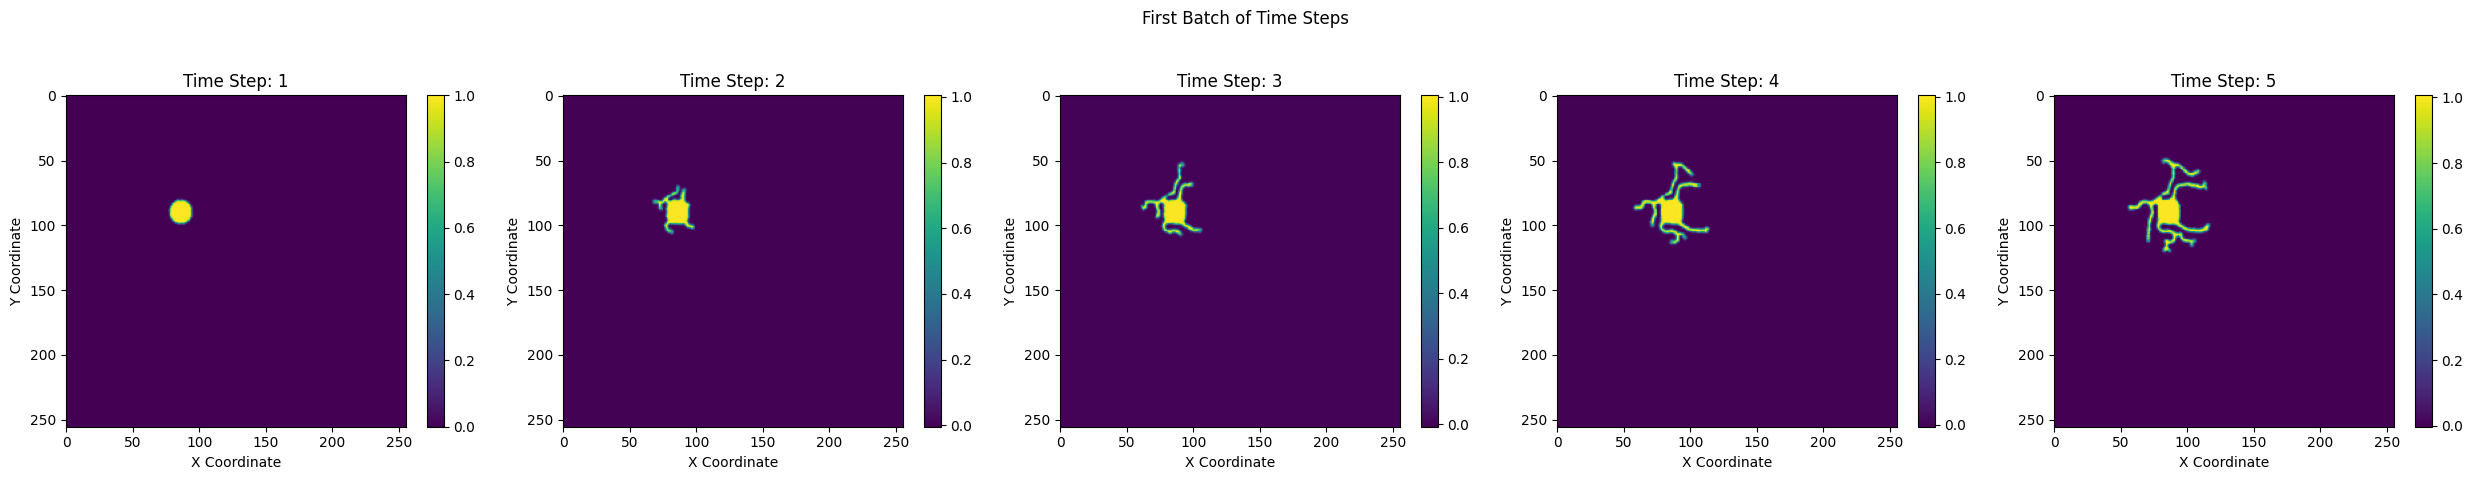

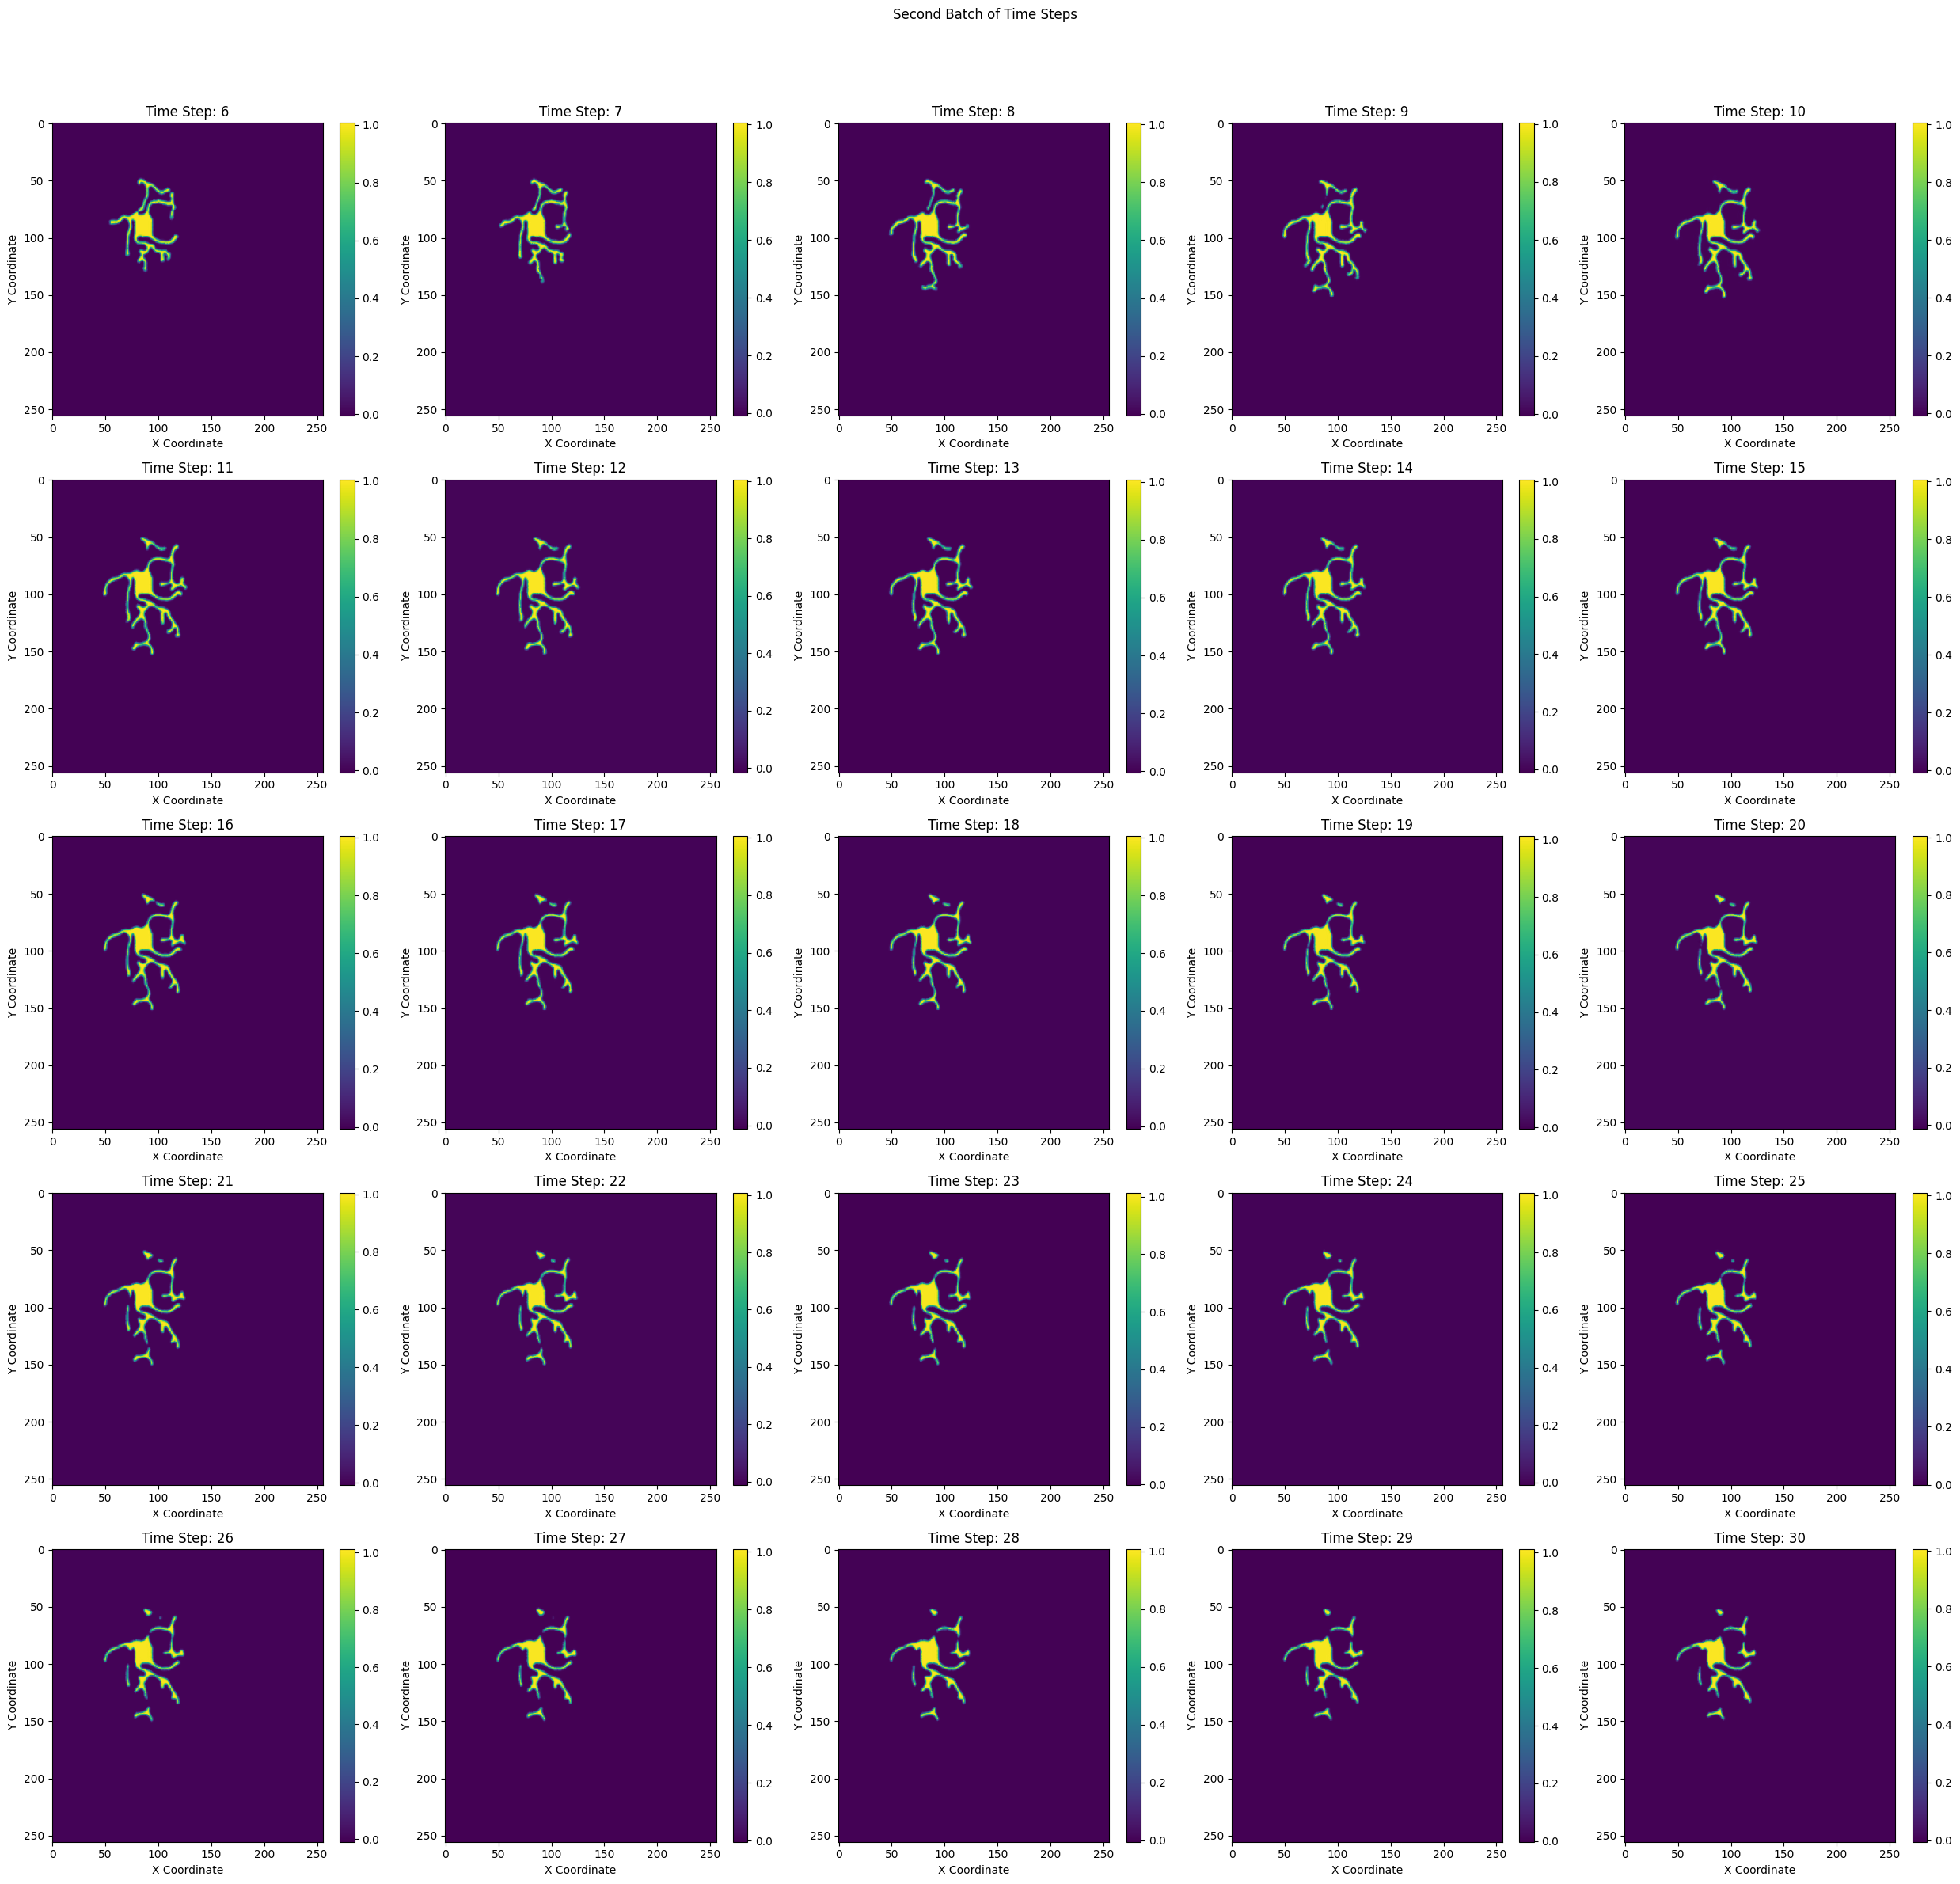

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_interpolated_time_steps(time_step_data, channel, split_at=5, columns_per_row=3):
    """
    Plots the specified channel from each time step's interpolated data, splitting the plots into two figures.

    Args:
        time_step_data (list of dicts): Each dict contains channel names as keys and 2D arrays of data as values.
        channel (str): Name of the channel to plot.
        split_at (int): Index at which to split the plots into a second figure.
        columns_per_row (int): Number of columns per row in the plot.

    Returns:
        None: Displays the plots.
    """
    
    num_time_steps = len(time_step_data)
    first_batch = min(num_time_steps, split_at)
    second_batch = num_time_steps - first_batch

    # Function to create plots for a given range of time steps
    def plot_batch(start_index, end_index, title):
        num_plots = end_index - start_index
        rows = (num_plots + columns_per_row - 1) // columns_per_row  # Calculate rows needed
        fig, axes = plt.subplots(rows, columns_per_row, figsize=(5 * columns_per_row, 5 * rows))
        if not isinstance(axes, np.ndarray):
            axes = np.array([axes])  # Handle the case where there is only one subplot
        axes = axes.flatten()

        for i in range(num_plots):
            ax = axes[i]
            data_index = start_index + i
            if channel in time_step_data[data_index]:
                c = ax.imshow(time_step_data[data_index][channel], cmap='viridis', aspect='auto')
                fig.colorbar(c, ax=ax)
                ax.set_title(f'Time Step: {data_index + 1}')
                ax.set_xlabel('X Coordinate')
                ax.set_ylabel('Y Coordinate')
            else:
                ax.set_title(f'Channel {channel} not found')
                ax.set_xlabel('X Coordinate')
                ax.set_ylabel('Y Coordinate')
                print(f"Warning: Channel '{channel}' not found in time step {data_index + 1}.")

        for j in range(i + 1, len(axes)):  # Hide unused axes
            axes[j].axis('off')

        plt.suptitle(title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # Plot the first batch of time steps
    plot_batch(0, first_batch, "First Batch of Time Steps")

    # Plot the second batch of time steps if there are any
    if second_batch > 0:
        plot_batch(first_batch, num_time_steps, "Second Batch of Time Steps")

# Randomly select a case key from all_cases_data
case_key = random.choice(list(all_cases_data.keys()))  # Randomly pick a case key
channel_to_plot = 'phi'  # Example channel to plot

# Now use the variable to access data and call the plotting function
plot_interpolated_time_steps(all_cases_data[case_key][0], channel_to_plot, columns_per_row=5)


In [5]:
import numpy as np
import random

def select_and_structure_data(all_cases_data, num_X_steps=10, num_Y_steps=20, train_frac=0.7, val_frac=0.15, channels=None):
    """
    Structured data extraction for ML training from multidimensional time-series data.

    Args:
        all_cases_data (dict): The main dataset containing all cases.
        num_X_steps (int): Number of time steps to use for X.
        num_Y_steps (int): Number of time steps to use for Y.
        train_frac (float): Fraction of data to be used for training.
        val_frac (float): Fraction of data to be used for validation.
        channels (list): List of channel names to include in the output arrays.

    Returns:
        dict: Dataset containing structured data for training, validation, and testing.
    """

    # Extract keys for all cases
    case_keys = list(all_cases_data.keys())
    random.shuffle(case_keys)

    # Determine split indices
    num_train = int(len(case_keys) * train_frac)
    num_val = int(len(case_keys) * val_frac)
    
    train_keys = case_keys[:num_train]
    val_keys = case_keys[num_train:num_train + num_val]
    test_keys = case_keys[num_train + num_val:]

    # Define function to extract data for X and Y
    def extract_data(cases, num_X_steps, num_Y_steps, channels):
        X, Y = [], []
        for case in cases:
            case_data = all_cases_data[case][0]  # Assuming the data structure is (list of dicts with channel data, grid_x, grid_y)
            # print(case_data)
            print(case)
            case_data[0]['phi']
            if len(case_data) >= num_X_steps + num_Y_steps:
                x_segments = np.stack([np.array([time_step[channel] for time_step in case_data[:num_X_steps]]) for channel in channels if channel in case_data[0]], axis=1)
                y_segments = np.stack([np.array([time_step[channel] for time_step in case_data[num_X_steps:num_X_steps + num_Y_steps]]) for channel in channels if channel in case_data[0]], axis=1)

                X.append(x_segments)
                Y.append(y_segments)

        return np.array(X), np.array(Y)

    # Extract data for each dataset
    X_train, Y_train = extract_data(train_keys, num_X_steps, num_Y_steps, channels)
    X_val, Y_val = extract_data(val_keys, num_X_steps, num_Y_steps, channels)
    X_test, Y_test = extract_data(test_keys, num_X_steps, num_Y_steps, channels)

    return {
        'X_train': X_train, 'Y_train': Y_train,
        'X_val': X_val, 'Y_val': Y_val,
        'X_test': X_test, 'Y_test': Y_test
    }

# Example usage: specify which channels to include
# channels_to_include = ['phi', 'synaptogenesis', 'tubulin', 'tips', 'theta']  # Add your specific channels here
channels_to_include = ['phi']  # Add your specific channels here
dataset = select_and_structure_data(all_cases_data, channels=channels_to_include)

# Display the shapes of the datasets
for key in dataset:
    print(f"{key} shape: {dataset[key].shape if dataset[key].size else 'Empty'}")

io2D_ND27
io2D_ND82
io2D_ND86
io2D_ND88
io2D_2_49
io2D_ND21
io2D_ND25
io2D_ND02
io2D_ND100
io2D_ND41
io2D_ND23
io2D_ND45
io2D_3_12
io2D_ND33
io2D_ND70
io2D_ND13
io2D_ND35
io2D_ND67
io2D_ND22
io2D_ND64
io2D_ND39
io2D_ND03
io2D_ND60
io2D_ND38
io2D_2_12
io2D_ND32
io2D_ND81
io2D_ND57
io2D_ND09
io2D_ND36
io2D_ND08
io2D_ND91
io2D_ND49
io2D_3_29
io2D_ND61
io2D_ND95
io2D_ND73
io2D_2_9
io2D_2_28
io2D_2_3
io2D_ND66
io2D_ND87
io2D_ND65
io2D_3_23
io2D_ND69
io2D_ND43
io2D_2_42
io2D_ND94
io2D_ND04
io2D_2_13
io2D_ND74
io2D_ND26
io2D_ND96
io2D_ND53
io2D_ND77
io2D_ND90
io2D_2_14
io2D_2_33
io2D_ND71
io2D_ND93
io2D_ND84
io2D_ND92
io2D_ND28
io2D_2_25
io2D_ND85
io2D_ND83
io2D_ND52
io2D_ND54
io2D_ND15
io2D_ND76
io2D_3_6
io2D_2_18
io2D_ND72
io2D_2_31
io2D_ND99
io2D_2_32
io2D_ND16
io2D_ND51
io2D_ND19
io2D_ND55
io2D_ND47
io2D_ND18
io2D_2_0
io2D_ND07
io2D_2_7
io2D_ND56
io2D_ND46
io2D_2_8
io2D_ND40
io2D_ND20
io2D_ND42
io2D_ND68
io2D_ND17
io2D_ND75
io2D_ND34
io2D_2_6
io2D_2_11
io2D_ND37
io2D_ND24
io2D_ND01
io2D_N

In [6]:
import pickle

# Save the dataset to a .pkl file using pickle
# with open('./reformatedNDDs/dataset_16k_20k.pkl', 'wb') as f:
# with open('./reformatedNDDs/dataset_16k_20k_all.pkl', 'wb') as f:
# with open('./reformatedNDDs/dataset_16k_20k_all_10042024.pkl', 'wb') as f:
# with open('./reformatedNDDs/dataset_16k_20k_all_10152024.pkl', 'wb') as f:
# with open('./reformatedNDDs/dataset_16k_20k_Dc.pkl', 'wb') as f:
with open('./reformatedNDDs/dataset_16k_20k_al_256_11282024.pkl', 'wb') as f:
    pickle.dump(dataset, f)